 <img src="../images/gfs.jpg" width=400 alt="Ideam_Logo"></img> 

# Global Forecast System - GFS

---

## Introducción
En este cuadernillo (Notebook) aprenderemos:

1. Introduccion al GFS
4. Uso del servidor Thredds
1. Consulta de datos del GFS a escala de 0.5 grados en resolución usando `siphon`
2. Visualización de variables pronosticadas

## Prerequisitos
| Conceptos | Importancia | Notas |
| --- | --- | --- |
| [Introducción a Xarray](https://foundations.projectpythia.org/core/xarray.html) | Necesario | lectura de datos multidimensionales |
| [Introducción a Datetime](https://foundations.projectpythia.org/core/datetime/datetime.html) | Necesario | Entender estampas de tiempo |
| [Introducción a  NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Útil | Entender la metadata de los datos |

- **Tiempo de aprendizaje**: 30 minutos

In [1]:
import xarray as xr
from siphon.catalog import TDSCatalog
import cartopy.crs as ccrs

## 1. GFS

In [2]:
gfs_url = 'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/latest.xml?dataset=grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20231006_1200.grib2'
best_gfs = TDSCatalog(gfs_url)
best_gfs

HTTPError: 404 Client Error: 404 for url: https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/latest.xml?dataset=grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20231006_1200.grib2

In [ ]:
ds_gfs = best_gfs.datasets[0].remote_access(use_xarray=True)
print(f'size: {ds_gfs.nbytes / (1024 ** 3)} GB')
display(ds_gfs)

In [ ]:
ds_gfs.time1

In [ ]:
(ds_gfs['Temperature_surface'].isel(time2=0) - 273.15).plot(cmap='coolwarm', vmin=-10, vmax=30)

In [ ]:
(ds_gfs['Temperature_surface'].isel(time2=0)- 273.15).plot(cmap='coolwarm', vmin=-10, vmax=30)

In [4]:
ds = xr.open_dataset("https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20231006_1200.grib2")

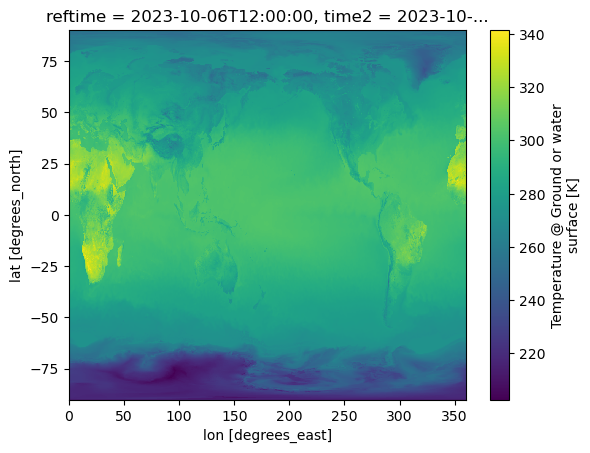

In [15]:
ds.isel(time2=0).Temperature_surface.plot()

## Librerias


---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!